In [ ]:
!pip install --upgrade \
  torch==2.6.0+cu124 torchvision==0.15.2+cu124 torchaudio==2.6.0+cu124 \
  --extra-index-url https://download.pytorch.org/whl/cu124

!pip install --upgrade \
  discopy>=1.1.0 \
  lambeq \
  pennylane pennylane-lightning \
  networkx


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.15.2+cu124 (from versions: 0.1.6, 0.2.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.0+cu124, 0.19.1, 0.19.1+cu124, 0.20.0, 0.20.0+cu124, 0.20.1, 0.20.1+cu124, 0.21.0, 0.21.0+cu124, 0.22.0, 0.22.1)
ERROR: No matching distribution found for torchvision==0.15.2+cu124



=== LSTM clásico ===
Epoch 0, Loss: 25.8864
Epoch 10, Loss: 10.4447
Epoch 20, Loss: 4.1279
Epoch 30, Loss: 1.2772
Epoch 40, Loss: 0.6153
Epoch 50, Loss: 0.3774
Epoch 60, Loss: 0.2605
Epoch 70, Loss: 0.1929
Epoch 80, Loss: 0.1495
Epoch 90, Loss: 0.1198

Generaciones de ejemplo:
Input: nlp procesa el -> Predicción: texto | Real: texto
Input: el modelo procesa -> Predicción: información | Real: información
Input: computación cuántica procesa -> Predicción: información | Real: información
Input: la computación nlp -> Predicción: modelo | Real: modelo
Input: la computación cuántica -> Predicción: procesa | Real: procesa
Input: la información texto -> Predicción: procesa | Real: procesa
Input: la información entrena -> Predicción: nlp | Real: nlp
Input: el modelo entrena -> Predicción: nlp | Real: nlp
Input: computación entrena nlp -> Predicción: modelo | Real: modelo
Input: el texto entrena -> Predicción: información | Real: información

=== QLSTM híbrido ===
Epoch 0, Loss: 27.2266
Epoch 1

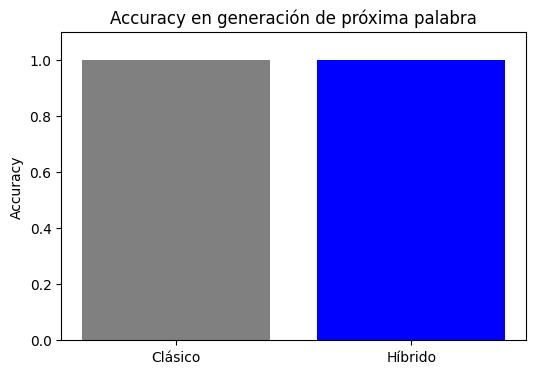

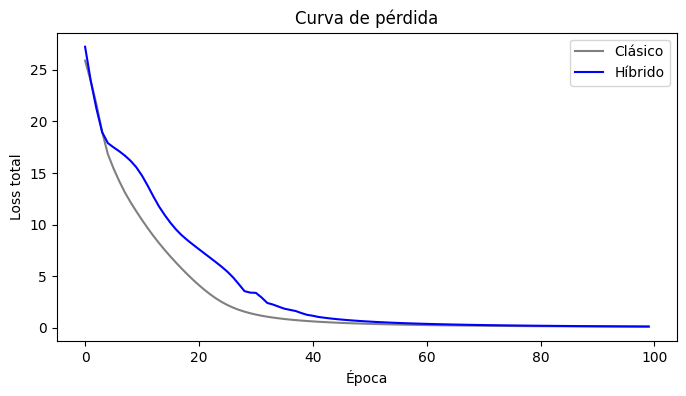

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import draw_mpl

vocabulario = ['la', 'computación', 'cuántica', 'procesa', 'información',
               'nlp', 'texto', 'modelo', 'entrena', 'el', 'clásica']
corpus = [
    ['la', 'computación', 'cuántica', 'procesa', 'información'],
    ['el', 'modelo', 'entrena', 'nlp'],
    ['nlp', 'procesa', 'el', 'texto'],
    ['la', 'información', 'entrena', 'nlp'],
    ['el', 'texto', 'procesa', 'modelo'],
    ['la', 'computación', 'nlp', 'modelo'],
    ['el', 'modelo', 'procesa', 'información'],
    ['la', 'información', 'texto', 'procesa'],
    ['computación', 'entrena', 'nlp', 'modelo'],
    ['el', 'texto', 'entrena', 'información']
]
vocab_size = len(vocabulario)
word2idx = {w: i for i, w in enumerate(vocabulario)}
idx2word = {i: w for i, w in enumerate(vocabulario)}

def generar_datos(corpus, tam_contexto=3):
    ejemplos = []
    for frase in corpus:
        for i in range(len(frase) - tam_contexto):
            entrada = frase[i:i+tam_contexto]
            salida = frase[i+tam_contexto]
            ejemplos.append((entrada, salida))
    return ejemplos

train_examples = generar_datos(corpus, tam_contexto=3)
test_examples = random.sample(train_examples, k=10)

def phrase_to_tensor(phrase):
    return torch.eye(vocab_size)[[word2idx[w] for w in phrase]]

def label_to_tensor(label):
    return torch.tensor([word2idx[label]])

class LSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.decoder = nn.Linear(hidden_size, vocab_size)
    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0)
        out, _ = self.lstm(input_seq)
        final_hidden = out[0, -1]
        return self.decoder(final_hidden)

n_qubits = 3
dev_hybrid = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev_hybrid, interface='torch')
def qlstm_circuit(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
        qml.Rot(*weights[i], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 0])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits):
        super().__init__()
        weight_shapes = {"weights": (n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(qlstm_circuit, weight_shapes)
        self.fc = nn.Linear(input_size + hidden_size, n_qubits)
        self.out = nn.Linear(n_qubits, hidden_size)
    def forward(self, x, h):
        combined = torch.cat([x, h], dim=-1)
        q_in = self.fc(combined)
        q_out = self.qlayer(q_in)
        return torch.tanh(self.out(q_out))

class QLSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = QLSTMCell(input_size, hidden_size, n_qubits)
        self.decoder = nn.Linear(hidden_size, vocab_size)
    def forward(self, input_seq):
        h = torch.zeros(self.hidden_size)
        for t in range(input_seq.shape[0]):
            h = self.cell(input_seq[t], h)
        return self.decoder(h)

def entrenar_y_evaluar(model, train_data, test_data, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for frase, label in train_data:
            x = phrase_to_tensor(frase)
            y = label_to_tensor(label)
            pred = model(x)
            loss = criterion(pred.unsqueeze(0), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

    print("\nGeneraciones de ejemplo:")
    correct = 0
    for frase, label in test_data:
        x = phrase_to_tensor(frase)
        with torch.no_grad():
            logits = model(x)
            pred_idx = torch.argmax(logits).item()
            pred = idx2word[pred_idx]
            print(f"Input: {' '.join(frase)} -> Predicción: {pred} | Real: {label}")
            if pred == label:
                correct += 1
    acc = correct / len(test_data)
    return losses, acc

results = {}

print("\n=== LSTM clásico ===")
lstm = LSTM_Generator(input_size=vocab_size, hidden_size=8, vocab_size=vocab_size)
losses_lstm, acc_lstm = entrenar_y_evaluar(lstm, train_examples, test_examples, epochs=100)
results['Clásico'] = (losses_lstm, acc_lstm)

print("\n=== QLSTM híbrido ===")
qlstm = QLSTM_Generator(input_size=vocab_size, hidden_size=8, n_qubits=3, vocab_size=vocab_size)
losses_qlstm, acc_qlstm = entrenar_y_evaluar(qlstm, train_examples, test_examples, epochs=100)
results['Híbrido'] = (losses_qlstm, acc_qlstm)

plt.figure(figsize=(6, 4))
for modelo, (_, acc) in results.items():
    plt.bar(modelo, acc, color={'Clásico': 'gray', 'Híbrido': 'blue'}[modelo])
plt.ylim(0, 1.1)
plt.title("Accuracy en generación de próxima palabra")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 4))
for modelo, (losses, _) in results.items():
    plt.plot(losses, label=modelo, color={'Clásico': 'gray', 'Híbrido': 'blue'}[modelo])
plt.xlabel("Época")
plt.ylabel("Loss total")
plt.title("Curva de pérdida")
plt.legend()
plt.show()


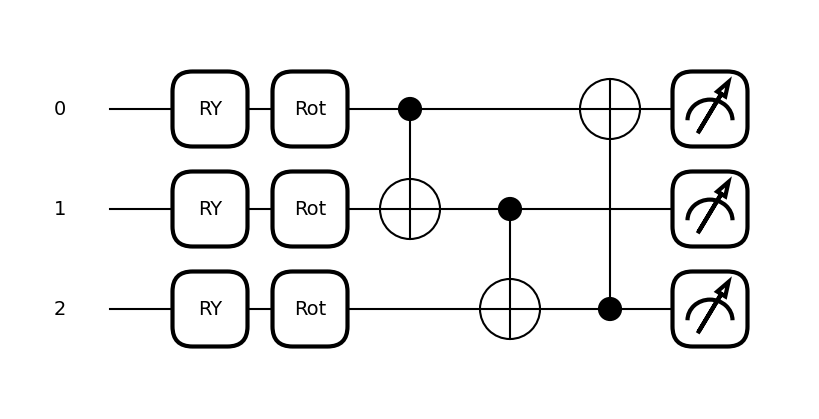

In [ ]:
fig, ax = qml.draw_mpl(qlstm_circuit_explicit)(example_input, example_weights)
plt.show()


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(



=== LSTM clásico ===


Época 1/100: 100%|██████████| 186/186 [00:01<00:00, 185.34it/s]


Epoch 0, Loss: 775.2651


Época 11/100: 100%|██████████| 186/186 [00:00<00:00, 460.76it/s]


Epoch 10, Loss: 195.8120


Época 21/100: 100%|██████████| 186/186 [00:00<00:00, 447.06it/s]


Epoch 20, Loss: 57.4735


Época 31/100: 100%|██████████| 186/186 [00:00<00:00, 321.20it/s]


Epoch 30, Loss: 22.8873


Época 41/100: 100%|██████████| 186/186 [00:00<00:00, 473.83it/s]


Epoch 40, Loss: 7.9424


Época 51/100: 100%|██████████| 186/186 [00:00<00:00, 485.91it/s]


Epoch 50, Loss: 3.7229


Época 61/100: 100%|██████████| 186/186 [00:00<00:00, 238.64it/s]


Epoch 60, Loss: 1.7299


Época 71/100: 100%|██████████| 186/186 [00:00<00:00, 453.88it/s]


Epoch 70, Loss: 1.6192


Época 81/100: 100%|██████████| 186/186 [00:00<00:00, 425.78it/s]


Epoch 80, Loss: 0.9468


Época 91/100: 100%|██████████| 186/186 [00:00<00:00, 439.72it/s]


Epoch 90, Loss: 0.5712


Época 100/100: 100%|██████████| 186/186 [00:00<00:00, 224.74it/s]



Generaciones de ejemplo:
Input: la comunidad de -> Predicción: madrid | Real: madrid
Input: con gravísimas consecuencias -> Predicción: mientras | Real: mientras
Input: de lo previsto -> Predicción: según | Real: según
Input: en dothan alabama -> Predicción: este | Real: este
Input: en canarias los -> Predicción: vientos | Real: vientos
Input: varios centros de -> Predicción: votación | Real: votación
Input: de la suscripción -> Predicción: digital | Real: digital
Input: condiciones de la -> Predicción: suscripción | Real: suscripción
Input: están actuando a -> Predicción: pleno | Real: pleno
Input: de la suscripción -> Predicción: digital | Real: digital

=== QLSTM híbrido ===


Época 1/100: 100%|██████████| 186/186 [00:11<00:00, 15.58it/s]


Epoch 0, Loss: 828.2513


Época 11/100: 100%|██████████| 186/186 [00:08<00:00, 22.70it/s]


Epoch 10, Loss: 487.3095


Época 21/100: 100%|██████████| 186/186 [00:08<00:00, 22.28it/s]


Epoch 20, Loss: 436.3036


Época 31/100: 100%|██████████| 186/186 [00:08<00:00, 21.77it/s]


Epoch 30, Loss: 407.3925


Época 41/100: 100%|██████████| 186/186 [00:07<00:00, 23.88it/s]


Epoch 40, Loss: 354.9066


Época 51/100: 100%|██████████| 186/186 [00:08<00:00, 21.55it/s]


Epoch 50, Loss: 324.5020


Época 61/100: 100%|██████████| 186/186 [00:09<00:00, 20.51it/s]


Epoch 60, Loss: 307.1249


Época 71/100: 100%|██████████| 186/186 [00:08<00:00, 21.93it/s]


Epoch 70, Loss: 265.7366


Época 81/100: 100%|██████████| 186/186 [00:08<00:00, 22.49it/s]


Epoch 80, Loss: 266.0926


Época 91/100: 100%|██████████| 186/186 [00:08<00:00, 21.00it/s]


Epoch 90, Loss: 253.8077


Época 100/100: 100%|██████████| 186/186 [00:08<00:00, 22.97it/s]



Generaciones de ejemplo:
Input: la comunidad de -> Predicción: un | Real: madrid
Input: con gravísimas consecuencias -> Predicción: mientras | Real: mientras
Input: de lo previsto -> Predicción: autoridades | Real: según
Input: en dothan alabama -> Predicción: su | Real: este
Input: en canarias los -> Predicción: su | Real: vientos
Input: varios centros de -> Predicción: la | Real: votación
Input: de la suscripción -> Predicción: digital | Real: digital
Input: condiciones de la -> Predicción: suscripción | Real: suscripción
Input: están actuando a -> Predicción: los | Real: pleno
Input: de la suscripción -> Predicción: digital | Real: digital


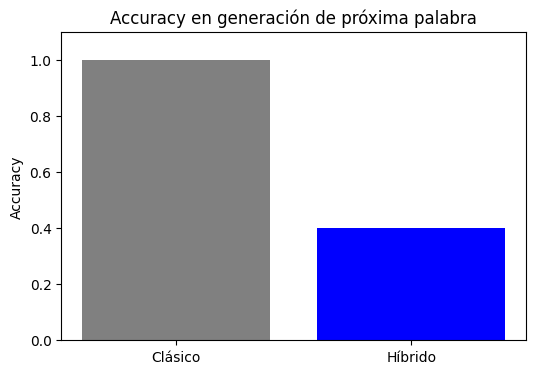

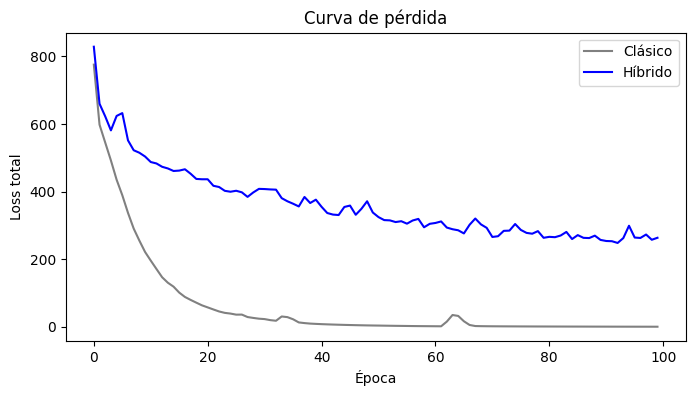

In [ ]:
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from tqdm import tqdm

# =================== 1. Cargar y preparar el corpus ===================
df = pd.read_csv("corpus_frases.csv")
frases = df["frase"].dropna().tolist()
tokenizadas = [f.lower().split() for f in frases if isinstance(f, str)]
tokenizadas = [f for f in tokenizadas if len(f) >= 4 and all(w.isalpha() for w in f)]

MAX_EJEMPLOS = 300
tokenizadas = tokenizadas[:MAX_EJEMPLOS]

palabras = sorted(set(word for frase in tokenizadas for word in frase))
vocab_size = len(palabras)
word2idx = {w: i for i, w in enumerate(palabras)}
idx2word = {i: w for i, w in enumerate(palabras)}

def generar_datos(corpus, tam_contexto=3):
    ejemplos = []
    for frase in corpus:
        for i in range(len(frase) - tam_contexto):
            entrada = frase[i:i+tam_contexto]
            salida = frase[i+tam_contexto]
            ejemplos.append((entrada, salida))
    return ejemplos

train_examples = generar_datos(tokenizadas, tam_contexto=3)
test_examples = random.sample(train_examples, k=10)

def phrase_to_tensor(phrase):
    return torch.eye(vocab_size)[[word2idx[w] for w in phrase]]

def label_to_tensor(label):
    return torch.tensor([word2idx[label]])

# =================== 2. Modelos ===================
class LSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.decoder = nn.Linear(hidden_size, vocab_size)
    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0)
        out, _ = self.lstm(input_seq)
        final_hidden = out[0, -1]
        return self.decoder(final_hidden)

n_qubits = 3
dev_hybrid = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev_hybrid, interface='torch')
def qlstm_circuit(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
        qml.Rot(*weights[i], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 0])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits):
        super().__init__()
        weight_shapes = {"weights": (n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(qlstm_circuit, weight_shapes)
        self.fc = nn.Linear(input_size + hidden_size, n_qubits)
        self.out = nn.Linear(n_qubits, hidden_size)
    def forward(self, x, h):
        combined = torch.cat([x, h], dim=-1)
        q_in = self.fc(combined)
        q_out = self.qlayer(q_in)
        return torch.tanh(self.out(q_out))

class QLSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = QLSTMCell(input_size, hidden_size, n_qubits)
        self.decoder = nn.Linear(hidden_size, vocab_size)
    def forward(self, input_seq):
        h = torch.zeros(self.hidden_size)
        for t in range(input_seq.shape[0]):
            h = self.cell(input_seq[t], h)
        return self.decoder(h)

# =================== 3. Entrenamiento y evaluación ===================
def entrenar_y_evaluar(model, train_data, test_data, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for frase, label in tqdm(train_data, desc=f"Época {epoch+1}/{epochs}"):
            x = phrase_to_tensor(frase)
            y = label_to_tensor(label)
            pred = model(x)
            loss = criterion(pred.unsqueeze(0), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

    print("\nGeneraciones de ejemplo:")
    correct = 0
    for frase, label in test_data:
        x = phrase_to_tensor(frase)
        with torch.no_grad():
            logits = model(x)
            pred_idx = torch.argmax(logits).item()
            pred = idx2word[pred_idx]
            print(f"Input: {' '.join(frase)} -> Predicción: {pred} | Real: {label}")
            if pred == label:
                correct += 1
    acc = correct / len(test_data)
    return losses, acc

# =================== 4. Comparativa ===================
results = {}

print("\n=== LSTM clásico ===")
lstm = LSTM_Generator(input_size=vocab_size, hidden_size=8, vocab_size=vocab_size)
losses_lstm, acc_lstm = entrenar_y_evaluar(lstm, train_examples, test_examples, epochs=100)
results['Clásico'] = (losses_lstm, acc_lstm)

print("\n=== QLSTM híbrido ===")
qlstm = QLSTM_Generator(input_size=vocab_size, hidden_size=8, n_qubits=3, vocab_size=vocab_size)
losses_qlstm, acc_qlstm = entrenar_y_evaluar(qlstm, train_examples, test_examples, epochs=100)
results['Híbrido'] = (losses_qlstm, acc_qlstm)

# =================== 5. Gráficas ===================
plt.figure(figsize=(6, 4))
for modelo, (_, acc) in results.items():
    plt.bar(modelo, acc, color={'Clásico': 'gray', 'Híbrido': 'blue'}[modelo])
plt.ylim(0, 1.1)
plt.title("Accuracy en generación de próxima palabra")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 4))
for modelo, (losses, _) in results.items():
    plt.plot(losses, label=modelo, color={'Clásico': 'gray', 'Híbrido': 'blue'}[modelo])
plt.xlabel("Época")
plt.ylabel("Loss total")
plt.title("Curva de pérdida")
plt.legend()
plt.show()
